# Initial Setups

## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50, ResNet50_Weights
from time import localtime
from tqdm import tqdm

## Device Configuration

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Dataset

In [29]:
weights = ResNet50_Weights.IMAGENET1K_V2
transform = weights.transforms()

batch_size = 128

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training Functions

In [30]:
def train_epoch(net, criterion, optimizer, dataloader, teacher_model=None, params=None):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  train_loss = 0
  train_accuracy = 0
  i = 0

  net.train()
  for i, (x, y) in enumerate(tqdm(dataloader)):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    if teacher_model is not None:
        p_t = teacher_model(x)
        loss = criterion(p, y, p_t, params)
    else:
        loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()
    
    train_loss = epoch_loss / (i + 1)
    train_accuracy = epoch_true / epoch_all

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss, train_accuracy


def evaluate_epoch(net, criterion, dataloader, teacher_model=None, params=None):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  eval_loss = 0
  eval_accuracy = 0
  i = 0

  net.eval()
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    if teacher_model is not None:
        p_t = teacher_model(x)
        loss = criterion(p, y, p_t, params)
    else:
        loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    eval_loss = epoch_loss / (i + 1)
    eval_accuracy = epoch_true / epoch_all

  return eval_loss, eval_accuracy


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, criterion, optimizer, train_loader, val_loader=None, teacher_model=None, params=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for e in range(n_epochs):
        if teacher_model is not None:
            train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader, teacher_model, params)
            if val_loader is not None:
                val_loss, val_accuracy = evaluate_epoch(net, criterion, val_loader, teacher_model, params)
        else:
            train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader)
            if val_loader is not None:
                val_loss, val_accuracy = evaluate_epoch(net, criterion, val_loader)
        

        train_losses.append(train_loss)
        train_accuracies.append(float(train_accuracy))
        if val_loader is not None:
            val_losses.append(val_loss)
            val_accuracies.append(float(val_accuracy))

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
        if val_loader is not None:
            print(f'Validation Loss: {val_loss:.4f}\t\tValidation Accuracy: {val_accuracy:.2f}')
        else:
            print()
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Part A

## Define Teacher Model

In [5]:
resnet50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

params = resnet50_model.parameters()
for param in params:
    param.requires_grad = False

resnet50_model.fc = nn.Linear(in_features=2048, out_features=10, device=device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Linear Tuning

In [8]:
cross_entropy_criterion = nn.CrossEntropyLoss()
resnet50_optimizer = torch.optim.SGD(resnet50_model.fc.parameters(), lr=0.001, momentum=0.9)

train_loss, train_acc, test_loss, test_acc = train_model(
    resnet50_model, 20, cross_entropy_criterion, resnet50_optimizer, train_loader, test_loader
)

100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 1]	 [11:58:13]	Train Loss: 1.6061	Train Accuracy: 0.60	Validation Loss: 1.2085		Validation Accuracy: 0.70


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 2]	 [12:1:37]	Train Loss: 1.0873	Train Accuracy: 0.71	Validation Loss: 0.9850		Validation Accuracy: 0.72


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 3]	 [12:5:2]	Train Loss: 0.9398	Train Accuracy: 0.73	Validation Loss: 0.8941		Validation Accuracy: 0.73


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 4]	 [12:8:27]	Train Loss: 0.8669	Train Accuracy: 0.74	Validation Loss: 0.8387		Validation Accuracy: 0.74


100%|██████████| 391/391 [02:52<00:00,  2.26it/s]


[Epoch 5]	 [12:11:52]	Train Loss: 0.8209	Train Accuracy: 0.75	Validation Loss: 0.8020		Validation Accuracy: 0.75


100%|██████████| 391/391 [02:52<00:00,  2.26it/s]


[Epoch 6]	 [12:15:16]	Train Loss: 0.7870	Train Accuracy: 0.75	Validation Loss: 0.7770		Validation Accuracy: 0.75


100%|██████████| 391/391 [02:52<00:00,  2.26it/s]


[Epoch 7]	 [12:18:42]	Train Loss: 0.7605	Train Accuracy: 0.76	Validation Loss: 0.7551		Validation Accuracy: 0.76


100%|██████████| 391/391 [02:51<00:00,  2.27it/s]


[Epoch 8]	 [12:22:7]	Train Loss: 0.7412	Train Accuracy: 0.76	Validation Loss: 0.7390		Validation Accuracy: 0.76


100%|██████████| 391/391 [02:53<00:00,  2.26it/s]


[Epoch 9]	 [12:25:32]	Train Loss: 0.7266	Train Accuracy: 0.77	Validation Loss: 0.7262		Validation Accuracy: 0.76


100%|██████████| 391/391 [02:53<00:00,  2.26it/s]


[Epoch 10]	 [12:28:58]	Train Loss: 0.7110	Train Accuracy: 0.77	Validation Loss: 0.7132		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 11]	 [12:32:23]	Train Loss: 0.7005	Train Accuracy: 0.77	Validation Loss: 0.7034		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 12]	 [12:35:47]	Train Loss: 0.6889	Train Accuracy: 0.78	Validation Loss: 0.6914		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:51<00:00,  2.29it/s]


[Epoch 13]	 [12:39:10]	Train Loss: 0.6803	Train Accuracy: 0.78	Validation Loss: 0.6874		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 14]	 [12:42:35]	Train Loss: 0.6726	Train Accuracy: 0.78	Validation Loss: 0.6811		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 15]	 [12:45:59]	Train Loss: 0.6627	Train Accuracy: 0.78	Validation Loss: 0.6760		Validation Accuracy: 0.77


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 16]	 [12:49:24]	Train Loss: 0.6548	Train Accuracy: 0.79	Validation Loss: 0.6658		Validation Accuracy: 0.78


100%|██████████| 391/391 [02:51<00:00,  2.27it/s]


[Epoch 17]	 [12:52:49]	Train Loss: 0.6494	Train Accuracy: 0.79	Validation Loss: 0.6593		Validation Accuracy: 0.78


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 18]	 [12:56:12]	Train Loss: 0.6416	Train Accuracy: 0.79	Validation Loss: 0.6575		Validation Accuracy: 0.78


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


[Epoch 19]	 [12:59:37]	Train Loss: 0.6354	Train Accuracy: 0.79	Validation Loss: 0.6543		Validation Accuracy: 0.78


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


[Epoch 20]	 [13:3:0]	Train Loss: 0.6329	Train Accuracy: 0.79	Validation Loss: 0.6487		Validation Accuracy: 0.78


In [ ]:
torch.save(resnet50_model, 'best_resnet50.pt')

## Accuracy & Loss plots

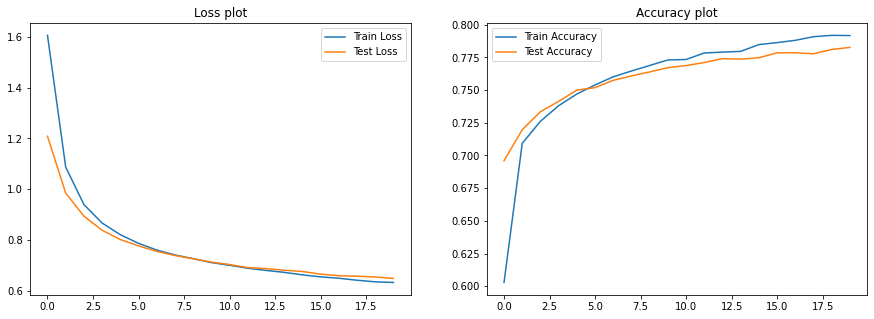

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(test_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Test Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(test_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Test Accuracy'])

# Part B

## Distiller Loss

In [42]:
def distiller_criterion(y_pred, y_true, y_pred_teacher, params):
    alpha, tau = params
    loss = cross_entropy_criterion(y_pred, y_true)
    teacher_pred = F.softmax(y_pred_teacher / tau, dim=1)
    student_pred = F.softmax(y_pred / tau, dim=1)
    distiller_loss = - (teacher_pred * torch.log(student_pred)).sum(axis=1).mean()
    return (1 - alpha) * loss + alpha * (tau ** 2) * distiller_loss

## Finding The best Hyperparameters ($\alpha$, $\tau$)

In [ ]:
for tau in [1, 2]:
    for alpha in [0.2, 0.5, 0.8]:
        resnet18_model = resnet18(weights=None).to(device)
        resnet18_model.fc = nn.Linear(in_features=512, out_features=10, device=device)
        resnet18_optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

        print(f'***** tau={tau}, alpha={alpha} *****')
        train_loss, train_acc, val_loss, val_acc = train_model(
            resnet18_model, 2, distiller_criterion, resnet18_optimizer,
            train_loader, test_loader, resnet50_model, (alpha, tau)
        )
        print()

***** tau=1, alpha=0.2 *****
[Epoch 1]	 [22:4:42]	Train Loss: 1.8108	Train Accuracy: 0.34	Validation Loss: 1.6237		Validation Accuracy: 0.41
[Epoch 2]	 [22:10:3]	Train Loss: 1.4919	Train Accuracy: 0.47	Validation Loss: 1.4472		Validation Accuracy: 0.49

***** tau=1, alpha=0.5 *****
[Epoch 1]	 [22:15:24]	Train Loss: 1.8418	Train Accuracy: 0.33	Validation Loss: 1.6277		Validation Accuracy: 0.43
[Epoch 2]	 [22:20:45]	Train Loss: 1.5361	Train Accuracy: 0.47	Validation Loss: 1.4835		Validation Accuracy: 0.50

***** tau=1, alpha=0.8 *****
[Epoch 1]	 [22:26:7]	Train Loss: 1.8635	Train Accuracy: 0.34	Validation Loss: 1.7024		Validation Accuracy: 0.41
[Epoch 2]	 [22:31:29]	Train Loss: 1.6141	Train Accuracy: 0.45	Validation Loss: 1.5437		Validation Accuracy: 0.49

***** tau=2, alpha=0.2 *****
[Epoch 1]	 [22:36:50]	Train Loss: 3.0972	Train Accuracy: 0.34	Validation Loss: 2.8603		Validation Accuracy: 0.42
[Epoch 2]	 [22:42:11]	Train Loss: 2.7290	Train Accuracy: 0.48	Validation Loss: 2.6844		Valida

## Train The Student Model with The Best Hyperparameters

In [11]:
best_alpha, best_tau = 0.5, 2

resnet18_model = resnet18(weights=None).to(device)
resnet18_model.fc = nn.Linear(in_features=512, out_features=10).to(device)
resnet18_optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

train_loss, train_acc, test_loss, test_acc = train_model(
    resnet18_model, 15, distiller_criterion, resnet18_optimizer,
    train_loader, test_loader, resnet50_model, (best_alpha, best_tau)
)

100%|██████████| 391/391 [04:32<00:00,  1.43it/s]


[Epoch 1]	 [13:11:57]	Train Loss: 4.9782	Train Accuracy: 0.34	Validation Loss: 4.6376		Validation Accuracy: 0.44


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 2]	 [13:17:10]	Train Loss: 4.5137	Train Accuracy: 0.49	Validation Loss: 4.4103		Validation Accuracy: 0.52


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 3]	 [13:22:24]	Train Loss: 4.3152	Train Accuracy: 0.55	Validation Loss: 4.3384		Validation Accuracy: 0.55


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 4]	 [13:27:39]	Train Loss: 4.1942	Train Accuracy: 0.60	Validation Loss: 4.2262		Validation Accuracy: 0.60


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 5]	 [13:32:52]	Train Loss: 4.1105	Train Accuracy: 0.64	Validation Loss: 4.1151		Validation Accuracy: 0.64


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 6]	 [13:38:6]	Train Loss: 4.0426	Train Accuracy: 0.67	Validation Loss: 4.1184		Validation Accuracy: 0.65


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 7]	 [13:43:21]	Train Loss: 3.9891	Train Accuracy: 0.69	Validation Loss: 4.0841		Validation Accuracy: 0.65


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 8]	 [13:48:35]	Train Loss: 3.9459	Train Accuracy: 0.71	Validation Loss: 4.0255		Validation Accuracy: 0.68


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 9]	 [13:53:49]	Train Loss: 3.9054	Train Accuracy: 0.73	Validation Loss: 3.9989		Validation Accuracy: 0.69


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 10]	 [13:59:3]	Train Loss: 3.8724	Train Accuracy: 0.75	Validation Loss: 3.9943		Validation Accuracy: 0.69


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 11]	 [14:4:17]	Train Loss: 3.8356	Train Accuracy: 0.77	Validation Loss: 4.0388		Validation Accuracy: 0.69


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 12]	 [14:9:30]	Train Loss: 3.8089	Train Accuracy: 0.78	Validation Loss: 3.9802		Validation Accuracy: 0.70


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 13]	 [14:14:44]	Train Loss: 3.7803	Train Accuracy: 0.80	Validation Loss: 3.9352		Validation Accuracy: 0.72


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 14]	 [14:19:59]	Train Loss: 3.7528	Train Accuracy: 0.81	Validation Loss: 3.9217		Validation Accuracy: 0.73


100%|██████████| 391/391 [04:35<00:00,  1.42it/s]


[Epoch 15]	 [14:25:12]	Train Loss: 3.7228	Train Accuracy: 0.83	Validation Loss: 3.9050		Validation Accuracy: 0.74


## Accuracy & Loss Plots

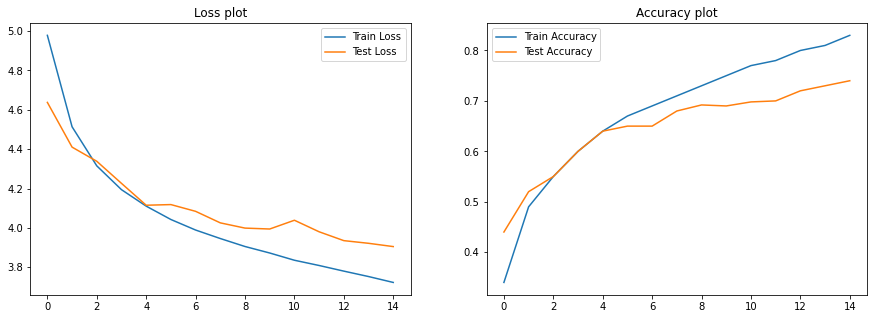

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(test_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Test Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(test_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Test Accuracy'])

# Part C

## Train ResNet18 without Teacher

In [21]:
resnet18_model = resnet18(weights=None).to(device)
resnet18_model.fc = nn.Linear(in_features=512, out_features=10).to(device)
resnet18_optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
cross_entropy_criterion = nn.CrossEntropyLoss()

train_loss, train_acc, test_loss, test_acc = train_model(
    resnet18_model, 15 , cross_entropy_criterion, resnet18_optimizer, train_loader, test_loader
)

100%|██████████| 391/391 [02:24<00:00,  2.70it/s]
[Epoch 1]	 [14:28:40]	Train Loss: 1.8211	Train Accuracy: 0.33	Validation Loss: 1.5923		Validation Accuracy: 0.41
100%|██████████| 391/391 [02:25<00:00,  2.68it/s]
[Epoch 2]	 [14:31:29]	Train Loss: 1.4480	Train Accuracy: 0.47	Validation Loss: 1.4119		Validation Accuracy: 0.49
100%|██████████| 391/391 [02:25<00:00,  2.69it/s]
[Epoch 3]	 [14:34:18]	Train Loss: 1.2763	Train Accuracy: 0.54	Validation Loss: 1.2643		Validation Accuracy: 0.53
100%|██████████| 391/391 [02:25<00:00,  2.69it/s]
[Epoch 4]	 [14:37:7]	Train Loss: 1.1497	Train Accuracy: 0.59	Validation Loss: 1.1680		Validation Accuracy: 0.58
100%|██████████| 391/391 [02:24<00:00,  2.70it/s]
[Epoch 5]	 [14:39:56]	Train Loss: 1.0467	Train Accuracy: 0.63	Validation Loss: 1.2910		Validation Accuracy: 0.56
100%|██████████| 391/391 [02:25<00:00,  2.69it/s]
[Epoch 6]	 [14:42:45]	Train Loss: 0.9613	Train Accuracy: 0.66	Validation Loss: 1.2215		Validation Accuracy: 0.59
100%|██████████| 391/39

## Accuracy & Loss Plots

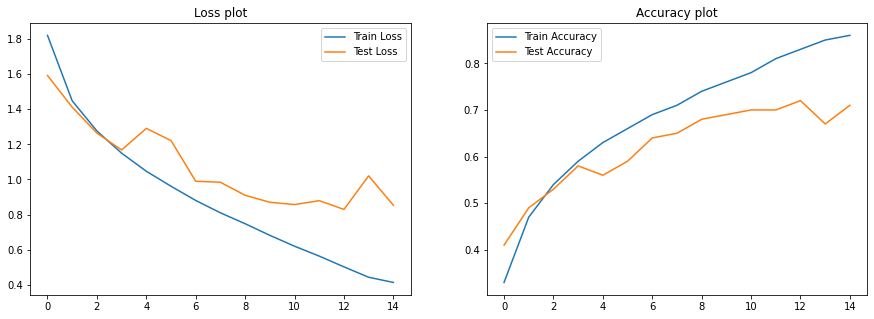

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(test_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Test Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(test_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Test Accuracy'])

## Training with Teacher vs Training itself

As we can see the student model train better when we use a more complex model as its teacher. The accuracy we reached when training with teacher is 0.74\% on test set while the accuracy we reached when there is no teacher model is 0.71\% at the same number of epochs.

The reason is teacher model tells the student model what the distribution of the probability of the output vector is (sometimes the input image could be visually similar to another class so we would want the output to have a higher probability on that class compaired to the other wrong classes). In the classic method we only push the output vector to have the highest probability on the correct class

It conclude that using the predictions and involving the loss of a complex model which has been trained on the data, to calculating the loss of a smaller model, can improve the accuacy of smaller model.

# Part D

## Fine Tuning Teacher Model

In [38]:
resnet50_model = resnet50(weights='IMAGENET1K_V2').to(device)
resnet50_model.fc = nn.Linear(in_features=2048, out_features=10, device=device)

params = resnet50_model.parameters()
for param in params: 
    param.requires_grad = True

In [39]:
cross_entropy_criterion = nn.CrossEntropyLoss()
resnet50_optimizer = torch.optim.SGD(resnet50_model.fc.parameters(), lr=0.001, momentum=0.9)

train_loss, train_acc, test_loss, test_acc = train_model(resnet50_model, 20, cross_entropy_criterion, resnet50_optimizer, train_loader, test_loader)

100%|██████████| 391/391 [01:11<00:00,  5.48it/s]


[Epoch 1]	 [16:50:1]	Train Loss: 1.6111	Train Accuracy: 0.60	Validation Loss: 1.2168		Validation Accuracy: 0.70


100%|██████████| 391/391 [01:11<00:00,  5.50it/s]


[Epoch 2]	 [16:51:27]	Train Loss: 1.0873	Train Accuracy: 0.71	Validation Loss: 0.9914		Validation Accuracy: 0.72


100%|██████████| 391/391 [01:11<00:00,  5.49it/s]


[Epoch 3]	 [16:52:52]	Train Loss: 0.9416	Train Accuracy: 0.73	Validation Loss: 0.8950		Validation Accuracy: 0.73


100%|██████████| 391/391 [01:11<00:00,  5.51it/s]


[Epoch 4]	 [16:54:18]	Train Loss: 0.8679	Train Accuracy: 0.74	Validation Loss: 0.8398		Validation Accuracy: 0.74


100%|██████████| 391/391 [01:12<00:00,  5.41it/s]


[Epoch 5]	 [16:55:45]	Train Loss: 0.8214	Train Accuracy: 0.75	Validation Loss: 0.8011		Validation Accuracy: 0.75


100%|██████████| 391/391 [01:10<00:00,  5.52it/s]


[Epoch 6]	 [16:57:10]	Train Loss: 0.7879	Train Accuracy: 0.75	Validation Loss: 0.7779		Validation Accuracy: 0.75


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


[Epoch 7]	 [16:58:35]	Train Loss: 0.7627	Train Accuracy: 0.76	Validation Loss: 0.7547		Validation Accuracy: 0.76


100%|██████████| 391/391 [01:11<00:00,  5.48it/s]


[Epoch 8]	 [17:0:1]	Train Loss: 0.7436	Train Accuracy: 0.76	Validation Loss: 0.7358		Validation Accuracy: 0.76


100%|██████████| 391/391 [01:10<00:00,  5.52it/s]


[Epoch 9]	 [17:1:26]	Train Loss: 0.7259	Train Accuracy: 0.77	Validation Loss: 0.7214		Validation Accuracy: 0.76


100%|██████████| 391/391 [01:10<00:00,  5.56it/s]


[Epoch 10]	 [17:2:51]	Train Loss: 0.7124	Train Accuracy: 0.77	Validation Loss: 0.7121		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:10<00:00,  5.56it/s]


[Epoch 11]	 [17:4:15]	Train Loss: 0.7014	Train Accuracy: 0.77	Validation Loss: 0.7060		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


[Epoch 12]	 [17:5:40]	Train Loss: 0.6899	Train Accuracy: 0.78	Validation Loss: 0.6907		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:10<00:00,  5.55it/s]


[Epoch 13]	 [17:7:5]	Train Loss: 0.6784	Train Accuracy: 0.78	Validation Loss: 0.6834		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:10<00:00,  5.53it/s]


[Epoch 14]	 [17:8:30]	Train Loss: 0.6695	Train Accuracy: 0.78	Validation Loss: 0.6770		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


[Epoch 15]	 [17:9:55]	Train Loss: 0.6624	Train Accuracy: 0.78	Validation Loss: 0.6716		Validation Accuracy: 0.77


100%|██████████| 391/391 [01:11<00:00,  5.44it/s]


[Epoch 16]	 [17:11:21]	Train Loss: 0.6557	Train Accuracy: 0.79	Validation Loss: 0.6669		Validation Accuracy: 0.78


100%|██████████| 391/391 [01:11<00:00,  5.46it/s]


[Epoch 17]	 [17:12:48]	Train Loss: 0.6468	Train Accuracy: 0.79	Validation Loss: 0.6579		Validation Accuracy: 0.78


100%|██████████| 391/391 [01:10<00:00,  5.53it/s]


[Epoch 18]	 [17:14:13]	Train Loss: 0.6426	Train Accuracy: 0.79	Validation Loss: 0.6541		Validation Accuracy: 0.78


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


[Epoch 19]	 [17:15:38]	Train Loss: 0.6369	Train Accuracy: 0.79	Validation Loss: 0.6508		Validation Accuracy: 0.78


100%|██████████| 391/391 [01:10<00:00,  5.53it/s]


[Epoch 20]	 [17:17:3]	Train Loss: 0.6309	Train Accuracy: 0.79	Validation Loss: 0.6475		Validation Accuracy: 0.78


## Accuracy & Loss Plots

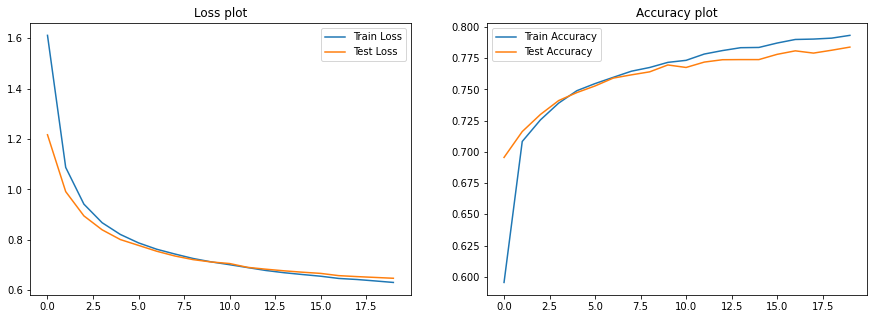

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(test_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Test Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(test_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Test Accuracy'])

## Train Student Model with Teacher

In [43]:
best_tau, best_alpha = (0.5, 15)

resnet18_model = resnet18(weights=None).to(device)
resnet18_model.fc = nn.Linear(in_features=512, out_features=10, bias=True).to(device)
resnet18_optimizer = torch.optim.Adam(resnet18_model.parameters())

train_loss, train_acc, test_loss, test_acc = train_model(
    resnet18_model, 15, distiller_criterion, resnet18_optimizer,
    train_loader, test_loader, resnet50_model, (best_tau, best_alpha)
)

100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 1]	 [17:19:40]	Train Loss: 258.7792	Train Accuracy: 0.54	Validation Loss: 258.6567		Validation Accuracy: 0.62


100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 2]	 [17:21:20]	Train Loss: 258.3603	Train Accuracy: 0.73	Validation Loss: 258.3797		Validation Accuracy: 0.74


100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 3]	 [17:23:0]	Train Loss: 258.2118	Train Accuracy: 0.80	Validation Loss: 258.3322		Validation Accuracy: 0.75


100%|██████████| 391/391 [01:25<00:00,  4.55it/s]


[Epoch 4]	 [17:24:41]	Train Loss: 258.1379	Train Accuracy: 0.84	Validation Loss: 258.1704		Validation Accuracy: 0.83


100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 5]	 [17:26:21]	Train Loss: 258.0788	Train Accuracy: 0.88	Validation Loss: 258.1844		Validation Accuracy: 0.83


100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 6]	 [17:28:1]	Train Loss: 258.0328	Train Accuracy: 0.90	Validation Loss: 258.1739		Validation Accuracy: 0.84


100%|██████████| 391/391 [01:25<00:00,  4.56it/s]


[Epoch 7]	 [17:29:42]	Train Loss: 257.9925	Train Accuracy: 0.93	Validation Loss: 258.1175		Validation Accuracy: 0.86


100%|██████████| 391/391 [01:26<00:00,  4.55it/s]


[Epoch 8]	 [17:31:22]	Train Loss: 257.9519	Train Accuracy: 0.95	Validation Loss: 258.1446		Validation Accuracy: 0.85


100%|██████████| 391/391 [01:26<00:00,  4.55it/s]


[Epoch 9]	 [17:33:3]	Train Loss: 257.9163	Train Accuracy: 0.97	Validation Loss: 258.1367		Validation Accuracy: 0.85


100%|██████████| 391/391 [01:26<00:00,  4.55it/s]


[Epoch 10]	 [17:34:43]	Train Loss: 257.8856	Train Accuracy: 0.98	Validation Loss: 258.1154		Validation Accuracy: 0.85


100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


[Epoch 11]	 [17:36:24]	Train Loss: 257.8612	Train Accuracy: 0.99	Validation Loss: 258.1146		Validation Accuracy: 0.86


100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


[Epoch 12]	 [17:38:4]	Train Loss: 257.8430	Train Accuracy: 0.99	Validation Loss: 258.1300		Validation Accuracy: 0.86


100%|██████████| 391/391 [01:26<00:00,  4.55it/s]


[Epoch 13]	 [17:39:45]	Train Loss: 257.8220	Train Accuracy: 0.99	Validation Loss: 258.0902		Validation Accuracy: 0.87


100%|██████████| 391/391 [01:26<00:00,  4.55it/s]


[Epoch 14]	 [17:41:25]	Train Loss: 257.8066	Train Accuracy: 0.99	Validation Loss: 258.1283		Validation Accuracy: 0.86


100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


[Epoch 15]	 [17:43:6]	Train Loss: 257.7916	Train Accuracy: 0.99	Validation Loss: 258.1132		Validation Accuracy: 0.87


## Accuracy & Loss Plots

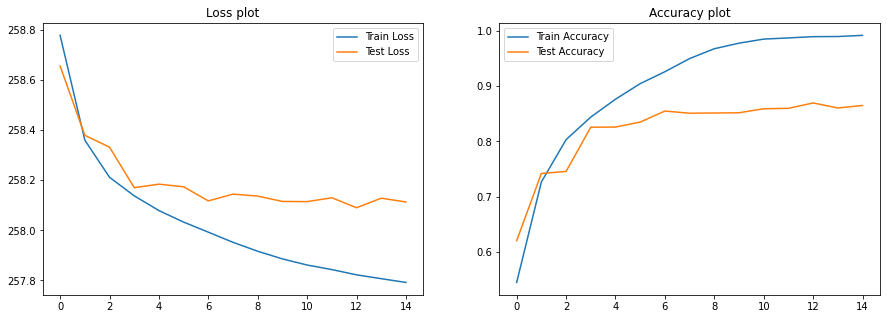

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.plot(test_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Test Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.plot(test_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Test Accuracy'])

## Linear Tuning vs. Fine Tuning

As we can see the results, linear tuning the teacher model leads to 74\% test accuracy of student model, but fine tuning the teaacher model leads to 87\% test accuracy of student model.

It is because we have more flexible model to train when we train whole model (Fine Tuning).

But the accuracy of linear tuning is also acceptable because the pretrained model has learned how to extract good feature for the classification task and we are only learning to re-use these features for new classification.